In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/optiver-realized-volatility-prediction/sample_submission.csv
/kaggle/input/optiver-realized-volatility-prediction/train.csv
/kaggle/input/optiver-realized-volatility-prediction/test.csv
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=97/888f813404d8417ca8d6b8aebd5f2951.parquet
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=43/bb0efa57f511470e817880842e3e2afa.parquet
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=21/1d8dc18ebfee47ffbb54b04e6afc0634.parquet
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=72/60f62a03d8854605901dda072c84db39.parquet
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=4/761268d671f9429abb29d9d2895e9bd2.parquet
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=112/cd283097a5b54293ba400a19e811a7f9.parquet
/kaggle/input/optiver-realized-volatility-pr

In [2]:
# Import relevant libraries
import pandas as pd
import numpy as np
import os
import glob
from functools import reduce
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras import backend as K
import tensorflow as tf

# Import training data
train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')

# Grab Unique Array IDs
stock_id_array = train.stock_id.unique()



We will now examine the structure of the data that we were provided.

In [3]:
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [4]:
train.shape

(428932, 3)

In [5]:
# Take a sample from the book data

sample = pd.read_parquet(f'../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=1')

In [6]:
sample.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.000754,1.001542,1.000689,1.001607,1,25,25,100
1,5,1,1.000754,1.001673,1.000689,1.001739,26,60,25,100
2,5,2,1.000754,1.001411,1.000623,1.001476,1,25,25,125
3,5,3,1.000754,1.001542,1.000689,1.001607,125,25,126,36
4,5,4,1.000754,1.001476,1.000623,1.001542,100,100,25,25


In [7]:
sample.shape

(1507532, 10)

**Feature Gathering**
Aside from the other features already given to us, we want to gather the 4 statistics that we can develop with our given data and that are most likely related to future realized volatility: Bid/Ask Spread (BAS), Weighted Average Price (WAP), Log Return, and Past Realized Volatility. Since BAS, WAP, and Log Returns are calculated upon each second in bucket, we will have to aggregate these so that there is only one BAS and WAP per time ID and stock ID pair. We will also need to aggregate the other features we are already given from the competition repository.

In [8]:
# Calculate Bid Ask Spread

# BAS calculation for a stock
def bas_calculation_per_id(stock_id, data_type):
    df_book_data = pd.read_parquet(f'../input/optiver-realized-volatility-prediction/book_{data_type}.parquet/stock_id={stock_id}')
    df_book_data['bas'] = df_book_data[['ask_price1', 'ask_price2']].min(axis=1)/df_book_data[['bid_price1', 'bid_price2']].max(axis=1) - 1
    df_book_data['stock_id'] = stock_id
    return df_book_data

# Loop through each stock
def bas_calculation(stock_id_array, data_type):
    df_bas = pd.DataFrame()
    for stock_id in stock_id_array:
        df_bas_id = bas_calculation_per_id(stock_id, data_type).groupby(by = ['stock_id', 'time_id'], as_index = False)['bas'].mean()
        df_bas = pd.concat([df_bas,df_bas_id])
    return df_bas

df_bas = bas_calculation(stock_id_array, 'train')
print(df_bas)

      stock_id  time_id       bas
0            0        5  0.000852
1            0       11  0.000394
2            0       16  0.000725
3            0       31  0.000861
4            0       62  0.000397
...        ...      ...       ...
3825       126    32751  0.000878
3826       126    32753  0.000706
3827       126    32758  0.000739
3828       126    32763  0.000530
3829       126    32767  0.000432

[428932 rows x 3 columns]


In [9]:
# Calculate Weighted Average Price

# WAP calculation for a stock
def wap_calculation_per_id(stock_id, data_type):
    df_book_data = pd.read_parquet(f'../input/optiver-realized-volatility-prediction/book_{data_type}.parquet/stock_id={stock_id}')
    df_book_data['stock_id'] = stock_id
    df_book_data['wap'] = (df_book_data['bid_price1'] * df_book_data['ask_size1'] + df_book_data['ask_price1'] 
                           * df_book_data['bid_size1']) / (df_book_data['bid_size1'] + df_book_data['ask_size1'])           
    return df_book_data[['stock_id', 'time_id', 'seconds_in_bucket', 'wap']]

# Loop through each stock
def wap_calculation(stock_id_array, data_type):
    df_wap = pd.DataFrame()
    for stock_id in stock_id_array:
        df_wap_id = wap_calculation_per_id(stock_id, data_type).groupby(by = ['stock_id', 'time_id'], as_index = False)['wap'].mean()
        df_wap = pd.concat([df_wap,df_wap_id])
    return df_wap

df_wap = wap_calculation(stock_id_array, 'train')
print(df_wap)

      stock_id  time_id       wap
0            0        5  1.003725
1            0       11  1.000239
2            0       16  0.999542
3            0       31  0.998832
4            0       62  0.999619
...        ...      ...       ...
3825       126    32751  0.999582
3826       126    32753  1.002476
3827       126    32758  1.001082
3828       126    32763  1.001809
3829       126    32767  1.000272

[428932 rows x 3 columns]


In [10]:
# Calculate Log Returns (LR)

# LR calculation for a list of stock prices
def lr(list_stock_prices):
    list_stock_prices['lr'] = np.log(list_stock_prices['wap']).diff()
    return list_stock_prices

# LR calculation for a stock
def lr_calculation_per_id(stock_id, data_type):
    df_book_data = wap_calculation_per_id(stock_id, data_type)
    df_lr_per_id = lr(df_book_data)
    return df_lr_per_id[['stock_id', 'time_id', 'seconds_in_bucket', 'lr']]

# Loop through each stock    
def lr_calculation(stock_id_array, data_type):
    df_lr = pd.DataFrame()
    for stock_id in stock_id_array:
        df_lr_id = lr_calculation_per_id(stock_id, data_type).groupby(by = ['stock_id', 'time_id'], as_index = False)['lr'].mean()
        df_lr = pd.concat([df_lr,df_lr_id])
    return df_lr

df_lr = lr_calculation(stock_id_array, 'train')
print(df_lr)

      stock_id  time_id            lr
0            0        5  7.613697e-06
1            0       11 -1.709351e-05
2            0       16 -1.439024e-05
3            0       31 -9.341130e-07
4            0       62  1.471145e-05
...        ...      ...           ...
3825       126    32751  2.216619e-06
3826       126    32753  2.729967e-05
3827       126    32758 -1.188287e-05
3828       126    32763 -4.598154e-06
3829       126    32767 -6.251299e-06

[428932 rows x 3 columns]


In [11]:
# Calculate Past Realized Volatility (RV)

# RV calculation for a series of LRs
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return['lr']**2))
    
# Loop through each stock
def rv_calculation(stock_id_array, data_type):
    df_rv = pd.DataFrame()
    for stock_id in stock_id_array:
        df_book_data = lr_calculation_per_id(stock_id, data_type)
        df_rv_id = df_book_data.groupby(by = ['stock_id', 'time_id'], as_index = False).apply(realized_volatility)
        df_rv_id.columns = ['stock_id', 'time_id', 'rv']
        df_rv = pd.concat([df_rv,df_rv_id])
    return df_rv

df_rv = rv_calculation(stock_id_array, 'train')
print(df_rv)

      stock_id  time_id        rv
0            0        5  0.004499
1            0       11  0.003966
2            0       16  0.002451
3            0       31  0.003742
4            0       62  0.003210
...        ...      ...       ...
3825       126    32751  0.003885
3826       126    32753  0.004424
3827       126    32758  0.005529
3828       126    32763  0.004216
3829       126    32767  0.002184

[428932 rows x 3 columns]


In [12]:
# Grab and Aggregate other given Relevant Features

# WAP calculation for a stock
def wap_calculation_per_id(stock_id, data_type):
    df_book_data = pd.read_parquet(f'../input/optiver-realized-volatility-prediction/book_{data_type}.parquet/stock_id={stock_id}')
    df_book_data['stock_id'] = stock_id
    df_book_data['wap'] = (df_book_data['bid_price1'] * df_book_data['ask_size1'] + df_book_data['ask_price1'] 
                           * df_book_data['bid_size1']) / (df_book_data['bid_size1'] + df_book_data['ask_size1'])           
    return df_book_data[['stock_id', 'time_id', 'seconds_in_bucket', 'wap']]

# Loop through each stock
def wap_calculation(stock_id_array, data_type):
    df_wap = pd.DataFrame()
    for stock_id in stock_id_array:
        df_wap_id = wap_calculation_per_id(stock_id, data_type).groupby(by = ['stock_id', 'time_id'], as_index = False)['wap'].mean()
        df_wap = pd.concat([df_wap,df_wap_id])
    return df_wap

df_wap = wap_calculation(stock_id_array, 'train')
print(df_wap)

      stock_id  time_id       wap
0            0        5  1.003725
1            0       11  1.000239
2            0       16  0.999542
3            0       31  0.998832
4            0       62  0.999619
...        ...      ...       ...
3825       126    32751  0.999582
3826       126    32753  1.002476
3827       126    32758  1.001082
3828       126    32763  1.001809
3829       126    32767  1.000272

[428932 rows x 3 columns]


In [13]:
# Gather and Aggregate other given features

# Grab features for each stock
def other_calculation_per_id(stock_id, data_type):
    df_book_data = pd.read_parquet(f'../input/optiver-realized-volatility-prediction/book_{data_type}.parquet/stock_id={stock_id}')
    df_book_data['stock_id'] = stock_id
    df = df_book_data.groupby(by = ['stock_id', 'time_id'], 
                      as_index = False)[['bid_price1', 'ask_price1', 'bid_price2', 
                      'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']].mean()
    df_two =  df_book_data.groupby(by = ['stock_id', 'time_id'],as_index = False)[['seconds_in_bucket']].max()
    return pd.merge(df, df_two,  how='left', left_on=['stock_id','time_id'], right_on = ['stock_id','time_id'])

# Loop through each stock
def other_calculation(stock_id_array, data_type):
    df_other = pd.DataFrame()
    for stock_id in stock_id_array:
        df_other_id = other_calculation_per_id(stock_id, data_type)
        df_other = pd.concat([df_other,df_other_id])
    return df_other

df_other = other_calculation(stock_id_array, 'train')
print(df_other)

      stock_id  time_id  bid_price1  ask_price1  bid_price2  ask_price2  \
0            0        5    1.003314    1.004169    1.003139    1.004320   
1            0       11    1.000011    1.000406    0.999870    1.000541   
2            0       16    0.999204    0.999929    0.999007    1.000127   
3            0       31    0.998445    0.999304    0.998255    0.999413   
4            0       62    0.999407    0.999804    0.999216    0.999913   
...        ...      ...         ...         ...         ...         ...   
3825       126    32751    0.998995    0.999873    0.998905    1.000075   
3826       126    32753    1.002018    1.002725    1.001891    1.002867   
3827       126    32758    1.000457    1.001196    1.000268    1.001388   
3828       126    32763    1.001611    1.002142    1.001468    1.002276   
3829       126    32767    1.000079    1.000511    0.999970    1.000669   

       bid_size1   ask_size1   bid_size2   ask_size2  seconds_in_bucket  
0      78.264901   74.579

In [14]:
# Concatonate each statistic into one dataframe

df_features = df_bas.merge(df_wap,on=['stock_id', 'time_id'])
df_features = df_features.merge(df_lr,on=['stock_id', 'time_id'])
df_features = df_features.merge(df_rv,on=['stock_id', 'time_id'])
df_features = df_features.merge(df_other,on=['stock_id', 'time_id'])
df_features = df_features.merge(train,on=['stock_id', 'time_id'])

# Delete rows with NaN or missing values
df_features = df_features.dropna()

# Make feature dataframe copy
df_features_copy = df_features
print(df_features)

        stock_id  time_id       bas       wap            lr        rv  \
0              0        5  0.000852  1.003725  7.613697e-06  0.004499   
1              0       11  0.000394  1.000239 -1.709351e-05  0.003966   
2              0       16  0.000725  0.999542 -1.439024e-05  0.002451   
3              0       31  0.000861  0.998832 -9.341130e-07  0.003742   
4              0       62  0.000397  0.999619  1.471145e-05  0.003210   
...          ...      ...       ...       ...           ...       ...   
428927       126    32751  0.000878  0.999582  2.216619e-06  0.003885   
428928       126    32753  0.000706  1.002476  2.729967e-05  0.004424   
428929       126    32758  0.000739  1.001082 -1.188287e-05  0.005529   
428930       126    32763  0.000530  1.001809 -4.598154e-06  0.004216   
428931       126    32767  0.000432  1.000272 -6.251299e-06  0.002184   

        bid_price1  ask_price1  bid_price2  ask_price2   bid_size1  \
0         1.003314    1.004169    1.003139    1.00432

Let us now explore stock ID 0 at all time IDs and try to spot the patterns within our features, if there exists any in the first place.

<AxesSubplot:xlabel='time_id', ylabel='target'>

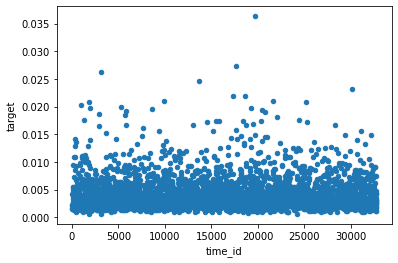

In [15]:
df_example = df_features.loc[(df_features['stock_id'] == 0)]

df_example.plot.scatter(x = "time_id", y = 'target')

Appears as though there is no correlation between time ID and realized volatility, so we will go on looking at the more relevant features we have gathered.

([<matplotlib.axis.YTick at 0x7fe818111990>,
 [Text(0, 0, 'bas'),
  Text(0, 1, 'wap'),
  Text(0, 2, 'lr'),
  Text(0, 3, 'rv'),
  Text(0, 4, 'seconds_in_bucket'),
  Text(0, 5, 'bid_price1'),
  Text(0, 6, 'ask_price1'),
  Text(0, 7, 'bid_price2'),
  Text(0, 8, 'ask_price2'),
  Text(0, 9, 'bid_size1'),
  Text(0, 10, 'ask_size1'),
  Text(0, 11, 'bid_size2'),
  Text(0, 12, 'ask_size2')])

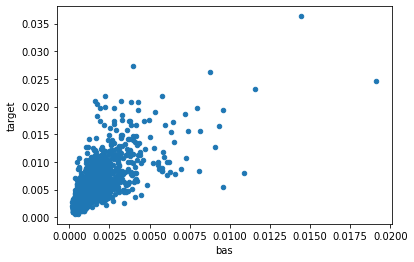

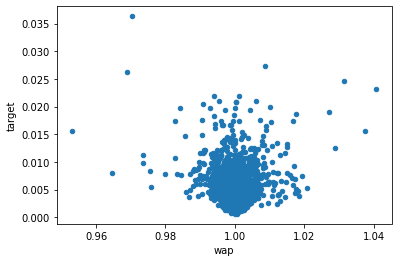

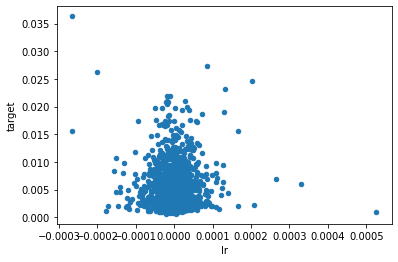

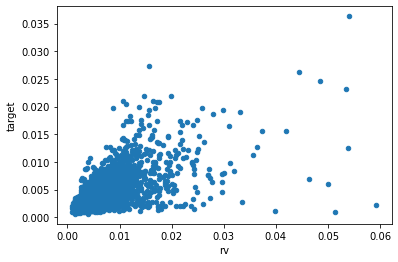

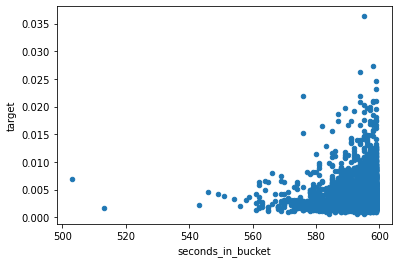

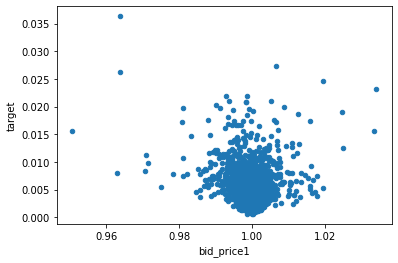

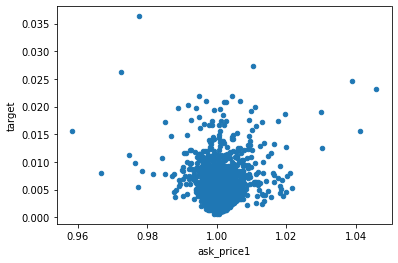

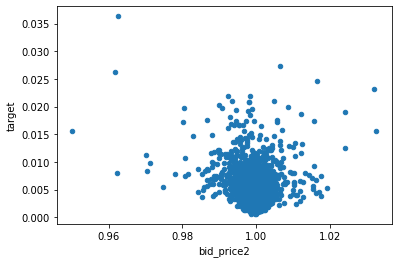

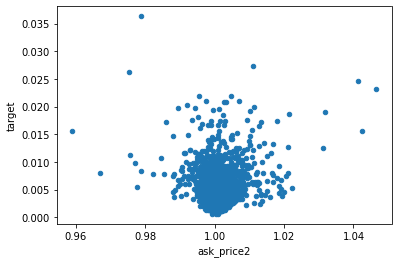

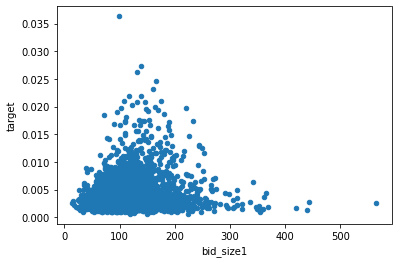

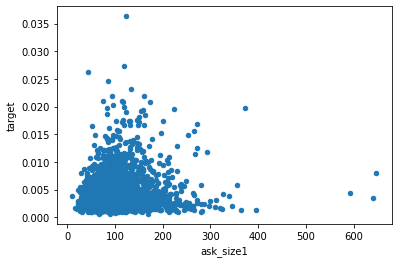

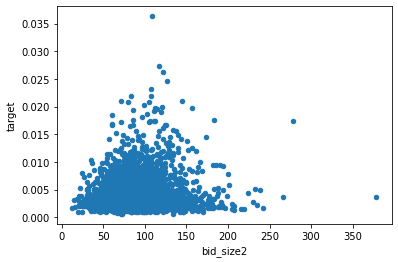

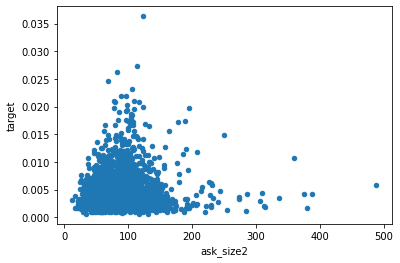

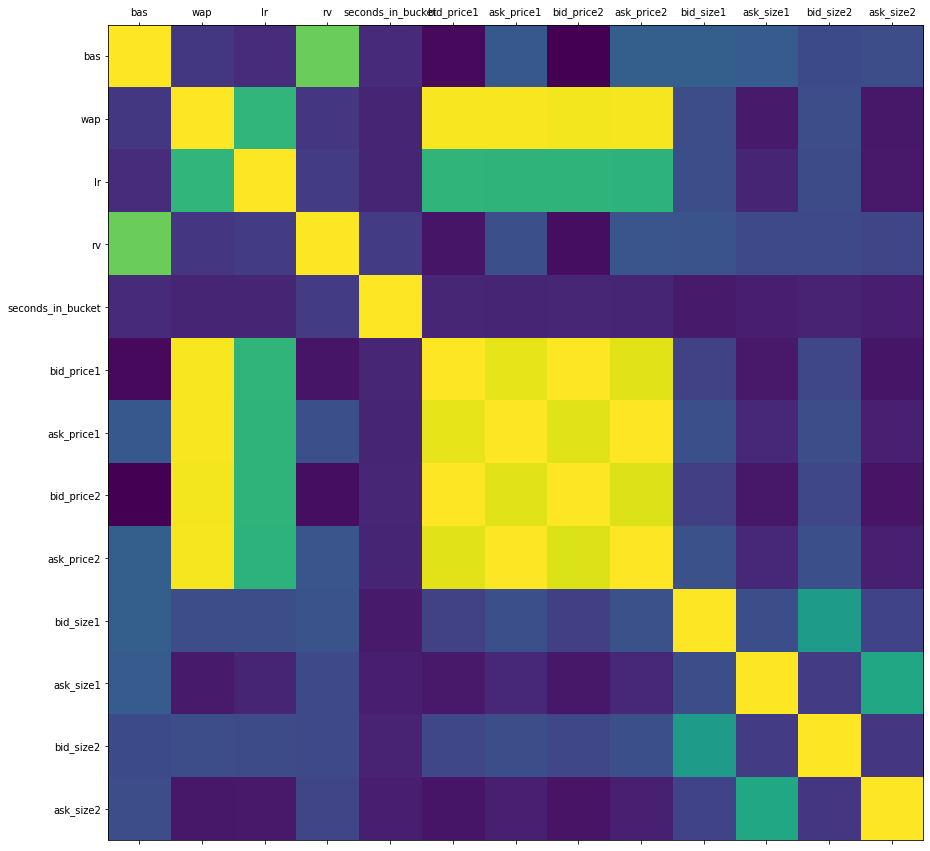

In [16]:
feature_array = ['bas', 'wap', 'lr', 'rv', 'seconds_in_bucket', 
                 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 
                 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']

for feature in feature_array:
    df_example.plot.scatter(x = feature, y = 'target')

corr = df_example[feature_array].corr()
fig, ax = plt.subplots(figsize=(15, 15))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)

There appears to be a relationship that we can capture with regression models between realized volatility, bid ask spread (and associated features), and past realized volatility. We will add the other features, which appear to have little correlation with realized volatility, to see if our later models can catch a pattern that we cannot see. The data also appears to need standardization before we train our models on them because of how small and spread out the feature data is. We will now apply standardization to all relevant features.

**Apply Standard Scaling**

In [17]:
scalers = []
for i in range(len(feature_array)):
    scaler = StandardScaler()
    feature = feature_array[i]
    df_features[feature] = scaler.fit_transform(np.asarray(df_features[feature]).reshape(-1,1))
    scalers.append(scaler)

([<matplotlib.axis.YTick at 0x7fe7f86b25d0>,
 [Text(0, 0, 'bas'),
  Text(0, 1, 'wap'),
  Text(0, 2, 'lr'),
  Text(0, 3, 'rv'),
  Text(0, 4, 'seconds_in_bucket'),
  Text(0, 5, 'bid_price1'),
  Text(0, 6, 'ask_price1'),
  Text(0, 7, 'bid_price2'),
  Text(0, 8, 'ask_price2'),
  Text(0, 9, 'bid_size1'),
  Text(0, 10, 'ask_size1'),
  Text(0, 11, 'bid_size2'),
  Text(0, 12, 'ask_size2')])

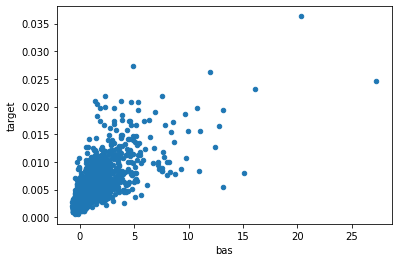

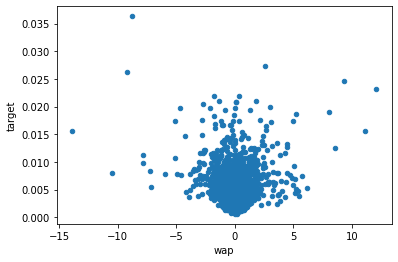

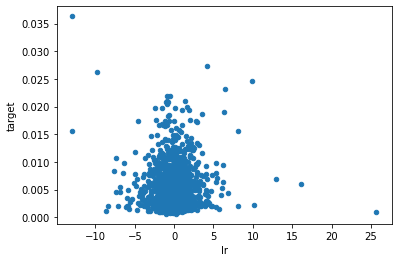

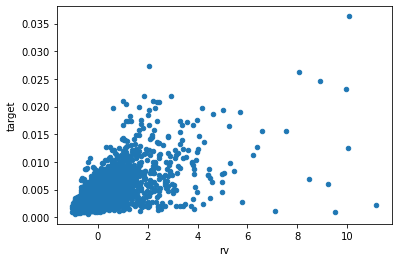

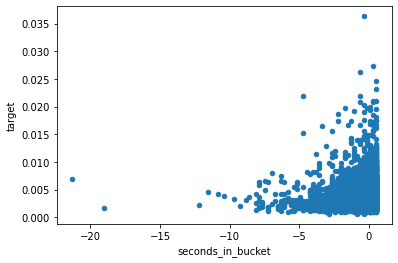

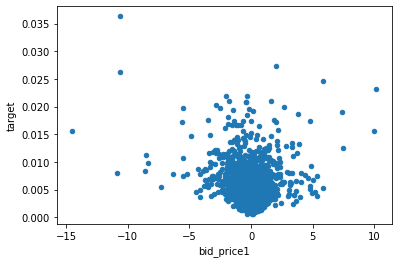

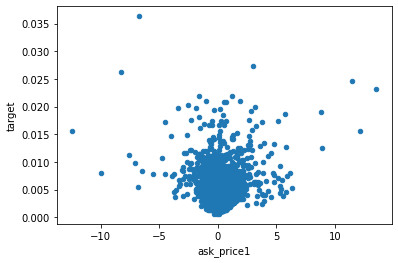

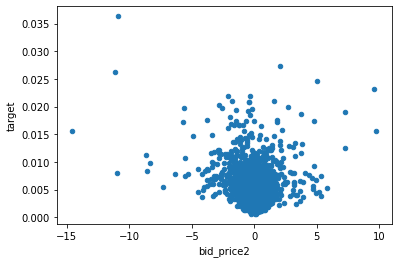

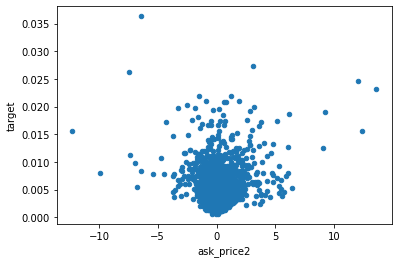

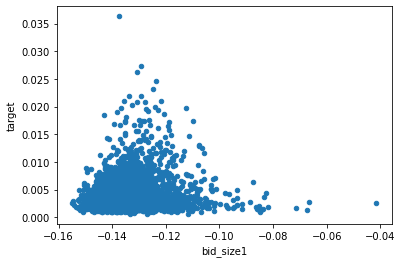

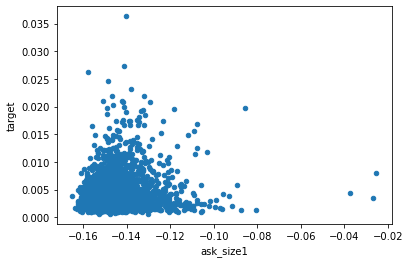

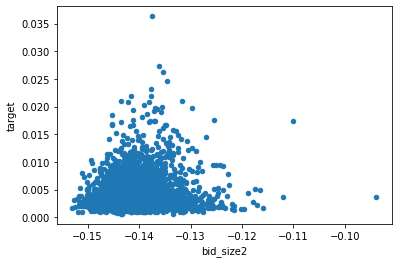

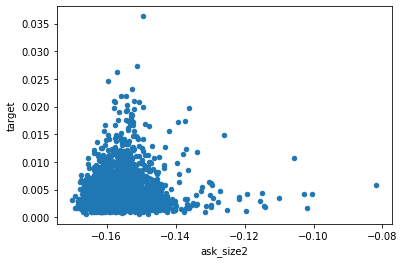

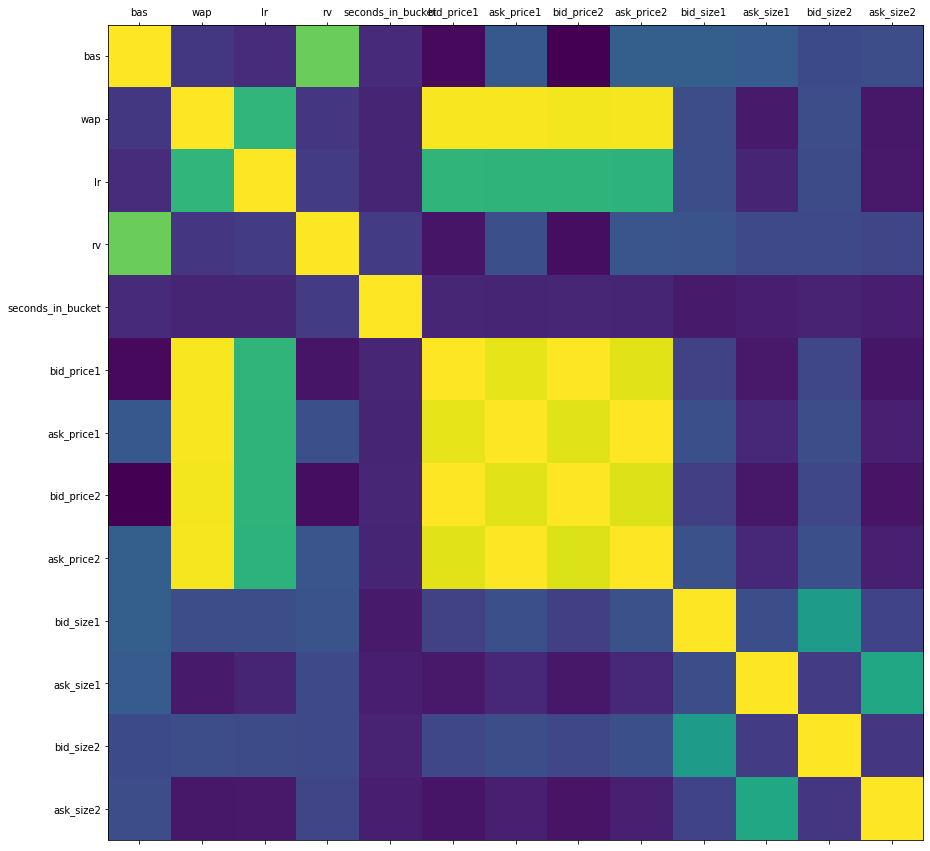

In [18]:
# Examine Data spread for stock ID 0 features again
df_example = df_features.loc[(df_features['stock_id'] == 0)]

for feature in feature_array:
    df_example.plot.scatter(x = feature, y = 'target')

corr = df_example[feature_array].corr()
fig, ax = plt.subplots(figsize=(15, 15))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)

Even with standardization, our features appear to follow the same pattern in relation to the target as they did pre-standardization. We will try out both standardized and pre-standardized training data in our following models.

**Linear Regression and XGBoost Regression**

In [19]:
# Train Test Splitting

X = df_features[feature_array]
Y = df_features['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = .9)

# Train Test Splitting for pre-standardized data

X_copy = df_features_copy[feature_array]
Y_copy = df_features_copy['target']

X_train_copy, X_test_copy, Y_train_copy, Y_test_copy = train_test_split(X_copy, Y_copy, train_size = .9)

In [20]:
# Linear Regression Model Fitting 

linreg_copy = LinearRegression().fit(X_train_copy, Y_train_copy)
print("Pre Standardization")
print("R2 Score: ")
print(linreg_copy.score(X_train_copy, Y_train_copy))
print("Coefficients: ")
print(linreg_copy.coef_)
print("Intercepts: ")
print(linreg_copy.intercept_)

linreg = LinearRegression().fit(X_train, Y_train)
print("Post Standardization")
print("R2 Score: ")
print(linreg.score(X_train, Y_train))
print("Coefficients: ")
print(linreg.coef_)
print("Intercepts: ")
print(linreg.intercept_)

Pre Standardization
R2 Score: 
0.6420883496869237
Coefficients: 
[-5.73545465e-03 -9.22553059e-04 -7.06510026e-05  7.91761402e-04
  3.27288829e-04 -3.36614115e-02  3.46803320e-02 -2.75780600e-03
  2.59420639e-03 -1.75167552e-05 -9.30391735e-05 -8.46304388e-05
 -2.00603221e-04]
Intercepts: 
0.0038803036499666277
Post Standardization
R2 Score: 
0.6423931508088481
Coefficients: 
[-5.27932091e-03 -1.14099539e-03 -7.09643535e-05  7.88746107e-04
  3.28605587e-04 -3.13970793e-02  3.23733451e-02 -2.64548603e-03
  2.74769627e-03 -1.69292665e-05 -9.64070324e-05 -8.16113573e-05
 -2.01640575e-04]
Intercepts: 
0.003880847362752774


In [21]:
# XGBoost Model Fitting 

regressor_copy = xgb.XGBRegressor(
    n_estimators=50,
    reg_lambda=1,
    gamma=0,
    max_depth=20
)

regressor_copy.fit(X_train_copy, Y_train_copy)


regressor = xgb.XGBRegressor(
    n_estimators=50,
    reg_lambda=1,
    gamma=0,
    max_depth=20
)

regressor.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
# Examine Feature Importance
print("Pre Standardization Feature Importance")
print(pd.DataFrame(regressor_copy.feature_importances_.reshape(1, -1), columns=feature_array))

print("Post Standardization Feature Importance")
print(pd.DataFrame(regressor.feature_importances_.reshape(1, -1), columns=feature_array))

Pre Standardization Feature Importance
        bas       wap        lr        rv  seconds_in_bucket  bid_price1  \
0  0.320594  0.025143  0.039399  0.254522           0.058045    0.056916   

   ask_price1  bid_price2  ask_price2  bid_size1  ask_size1  bid_size2  \
0    0.048558    0.036716    0.043638   0.029152   0.028323   0.031063   

   ask_size2  
0   0.027931  
Post Standardization Feature Importance
        bas       wap        lr        rv  seconds_in_bucket  bid_price1  \
0  0.322701  0.023695  0.041247  0.244656           0.053642    0.063798   

   ask_price1  bid_price2  ask_price2  bid_size1  ask_size1  bid_size2  \
0    0.069876    0.029897    0.031544   0.029823   0.028454   0.029801   

   ask_size2  
0   0.030866  


As expected, past bid ask spread and realized volatility had the most importance in determining future, followed by Log Return, and our other features with much less importance.

In [23]:
# Calculate Root Mean Squared Prediction Error (RMSPE)

def RMSPE(actual, predict):
    return (np.sqrt(np.mean(np.square((actual - predict) / actual))))

Y_predict_copy = linreg_copy.predict(X_test_copy)
error = RMSPE(Y_test_copy, Y_predict_copy)
print("Pre Standardization")
print("Linear Regression Error:")
print(error)
Y_predict_copy = regressor_copy.predict(X_test_copy)
error = RMSPE(Y_test_copy, Y_predict_copy)
print("XGBoost Error:")
print(error)


Y_predict = linreg.predict(X_test)
error = RMSPE(Y_test, Y_predict)
print("Post Standardization")
print("Linear Regression Error:")
print(error)
Y_predict = regressor.predict(X_test)
error = RMSPE(Y_test, Y_predict)
print("XGBoost Error:")
print(error)

Pre Standardization
Linear Regression Error:
0.5722120106264892
XGBoost Error:
0.3799545622742675
Post Standardization
Linear Regression Error:
0.5405170023867054
XGBoost Error:
0.37350569098203174


Higher than the error from the other naive approach given to us in Optiver's tutorial, but not terrible for a first approach. There are still quite a few things we could obviously optimize in terms of our XGBoost Regression model, which has almost default settings right now. Additionally, standardization appeared to help in our models (the results above may not show it, but the majority of times that this has run, standardization has helped), so we will use that for our predictions.

Since our XGBRegressor model with vanilla parameters did fairly well (below .4 RMSPE for both standardized and non-standardized data), we will be using the same model with tuned hyperparameters to make our final test predictions.

In [24]:
# XGBRegressor Hyperparameter Tuning

"""params = {
    'reg_lambda': [1],
    'gamma': [0],
    'learning_rate': [0.01, 0.1],
    'min_child_weight': [1, 3, 5],
    'n_estimators' : [50 ,100, 200],
    'max_depth': [20, 40, 60],
    'objective': ['reg:squarederror']
}

xgb_regressor = xgb.XGBRegressor()

gsearch = GridSearchCV(estimator = xgb_regressor,
                       param_grid = params,
                       # 2 Stratified Kfold
                       cv = 2,
                       # Use All Processors
                       n_jobs = -1,
                       # Display time taken per fold and paramater candidate is displayed
                       # Display score
                       verbose = 4)

gsearch.fit(X_train,Y_train)

print(gsearch.best_params_)"""

# May take 5+ hours to run. Run this only once if needed.

"params = {\n    'reg_lambda': [1],\n    'gamma': [0],\n    'learning_rate': [0.01, 0.1],\n    'min_child_weight': [1, 3, 5],\n    'n_estimators' : [50 ,100, 200],\n    'max_depth': [20, 40, 60],\n    'objective': ['reg:squarederror']\n}\n\nxgb_regressor = xgb.XGBRegressor()\n\ngsearch = GridSearchCV(estimator = xgb_regressor,\n                       param_grid = params,\n                       # 2 Stratified Kfold\n                       cv = 2,\n                       # Use All Processors\n                       n_jobs = -1,\n                       # Display time taken per fold and paramater candidate is displayed\n                       # Display score\n                       verbose = 4)\n\ngsearch.fit(X_train,Y_train)\n\nprint(gsearch.best_params_)"

In [25]:
# Test Best Hyperparameter Configuration on Validation Data

regressor = xgb.XGBRegressor(
    reg_lambda=1,
    gamma=0,
    max_depth=20,
    learning_rate=0.1,  
    min_child_weight=3, 
    n_estimators=200,
    objective='reg:squarederror'
)

regressor.fit(X_train, Y_train)

Y_predict = regressor.predict(X_test)
error = RMSPE(Y_test, Y_predict)
print("Hyperparameter Tuned XGBoost Error:")
print(error)

Hyperparameter Tuned XGBoost Error:
0.36024193087252826


We will now attempt to create a regression model from a Deep Neural Network (DNN) that aims to lower the best root mean squared error from our previous models. Due to computing constraints, we will only use standardized data on a single DNN.

The model will be as follows:

1 Input Layer with Relu Activation, 128 Units, and a input dimension that matches our training data shape
 
1 Hidden Layer with Relu Activation and 256 Units

1 Hidden Layer with Relu Activation and 128 Units

1 Hidden Layer with Relu Activation and 64 Units

1 Hidden Layer with Relu Activation and 32 Units

1 Hidden Layer with Relu Activation and 16 Units

1 Output Layer with Linear Activation and 1 Unit to match our output data shape

All layers will be kernel initalized to normal to match our standardized data and we will use the Adam optimizer as it appears to have give us the smoothest downward trend in our loss and validation loss history plot.

In [26]:
# Create RMSPE Function for the keras model
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

# Load Sequential to start forming our DNN
DNN = Sequential()

# The 128 Unit Input Layer:
DNN.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The 256 Unit Hidden Layer:
DNN.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The 128 Unit Hidden Layer:
DNN.add(Dense(128, kernel_initializer='normal',activation='relu'))

# The 64 Unit Hidden Layer:
DNN.add(Dense(64, kernel_initializer='normal',activation='relu'))

# The 32 Unit Hidden Layer
DNN.add(Dense(32, kernel_initializer='normal',activation='relu'))

# The 16 Unit Hidden Layer
DNN.add(Dense(16, kernel_initializer='normal',activation='relu'))

# The 1 Unit Outer Layer:
DNN.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network:
DNN.compile(loss=rmspe, optimizer='adam')
DNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1792      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [27]:
# Initialize Callbacks
"""my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]"""

# Fit the DNN to our training data
history = DNN.fit(X, Y, epochs=50, batch_size=128, validation_split = 0.2, verbose=1)

Epoch 1/50
2681/2681 [==============================] - 12s 4ms/step - loss: 0.3447 - val_loss: 0.2893
Epoch 2/50
2681/2681 [==============================] - 10s 4ms/step - loss: 0.3085 - val_loss: 0.2922
Epoch 3/50
2681/2681 [==============================] - 10s 4ms/step - loss: 0.3072 - val_loss: 0.2976
Epoch 4/50
2681/2681 [==============================] - 10s 4ms/step - loss: 0.3062 - val_loss: 0.3053
Epoch 5/50
2681/2681 [==============================] - 10s 4ms/step - loss: 0.3021 - val_loss: 0.3102
Epoch 6/50
2681/2681 [==============================] - 10s 4ms/step - loss: 0.3079 - val_loss: 0.2900
Epoch 7/50
2681/2681 [==============================] - 9s 4ms/step - loss: 0.3027 - val_loss: 0.3087
Epoch 8/50
2681/2681 [==============================] - 9s 4ms/step - loss: 0.3000 - val_loss: 0.2952
Epoch 9/50
2681/2681 [==============================] - 9s 3ms/step - loss: 0.3026 - val_loss: 0.2917
Epoch 10/50
2681/2681 [==============================] - 10s 4ms/step - loss

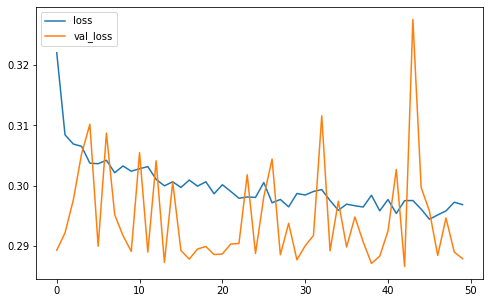

In [28]:
# Plot loss and validation loss per epoch
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Our DNN seems to have beaten our previous regression models in RMSPE by quite a bit, so we will be using it in our final predictions.

 **Predictions for the true test set**

In [29]:
# Import test Data

test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')

# Grab Unique Array IDs
stock_id_array = test.stock_id.unique()

df_bas = bas_calculation(stock_id_array, 'test')
df_wap = wap_calculation(stock_id_array, 'test')
df_lr = lr_calculation(stock_id_array, 'test')
df_rv = rv_calculation(stock_id_array, 'test')
df_other = other_calculation(stock_id_array, 'test')

# Concatonate each statistic into one dataframe

df_features = df_bas.merge(df_wap,on=['stock_id', 'time_id'])
df_features = df_features.merge(df_lr,on=['stock_id', 'time_id'])
df_features = df_features.merge(df_rv,on=['stock_id', 'time_id'])
df_features = df_features.merge(df_other,on=['stock_id', 'time_id'])
df_features = df_features.merge(test,on=['stock_id', 'time_id'])

# Standardize the feature data

for i in range(len(feature_array)):
    scaler = scalers[i]
    feature = feature_array[i]
    df_features[feature] = scaler.transform(np.asarray(df_features[feature]).reshape(-1,1))

# Make Predictions
X_predict = df_features[feature_array]
Y_predict = DNN.predict(X_predict)

data = []
for i in range(len(Y_predict)):
    data.append([str(df_features['stock_id'].iloc[i]) + "-" + str(df_features['time_id'].iloc[i]), Y_predict[i][0]])
df = pd.DataFrame(data, columns = ['row_id', 'target'])
df.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv')

,row_id,target
0,0-4,0.000644
